In [13]:
import json
import re
import pandas as pd
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
import requests
from bs4 import BeautifulSoup
import os


In [14]:
def extract_json_from_html(match_url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

    response = requests.get(match_url, headers=headers)
    if response.status_code != 200: raise f'Could Get Match Data\nStatus Code: {response.status_code}'
    html = BeautifulSoup(response.content, 'html.parser')
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, str(html))[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')
    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)
    df['match_period'] = df.apply(lambda row: row['period']['displayName'], axis=1)
    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType", "match_period"]]

    return df_passes

def get_touchs_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)
    df['match_period'] = df.apply(lambda row: row['period']['displayName'], axis=1)
    df_touches_ids = df.index[(df["isTouch"] == True)]
    df_touches = df.loc[
        df_touches_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "eventType", "outcomeType", "match_period", "minute", "second", "isTouch"]]

    return df_touches

def get_event_type_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)
    df['match_period'] = df.apply(lambda row: row['period']['displayName'], axis=1)
    df = df.drop(columns=['period', 'type'])
    return df

def get_shots_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)
    df['match_period'] = df.apply(lambda row: row['period']['displayName'], axis=1)
    df = df.drop(columns=['period', 'type'])

    df_shots_ids = df.index[(df["isShot"] == True)]
    df_shots = df.loc[
        df_shots_ids, df.columns]

    return df_shots

def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    #print(team_id)
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    #print(average_locs_and_count_df)

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df

def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
                                                / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size, marker='h',
                               color='#FEFEFC', edgecolors='#FEFEFC', linewidth=1, alpha=1, ax=ax)
    for _, row in average_locs_and_count_df.iterrows():
        #print(row)
        #player_name = row["name"].split()
        #player_initials = "".join(word[0] for word in player_name).upper()
        player_shirt = row["shirtNo"]
        pitch.annotate(player_shirt, xy=(row.x, row.y), c='#706f6f', va='center',
                       ha='center', size=14, ax=ax)

    return pitch

In [67]:
match_html_path = 'https://www.whoscored.com/Matches/1716741/Live/Brazil-Brasileir%C3%A3o-2023-Fluminense-Gremio'


json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)
events_df = get_event_type_df(events_dict)
passes_df = get_passes_df(events_dict)


home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)

away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)

BASE_DIR = os.path.join('..', 'data')
ENGINEERED_DIR = os.path.join(BASE_DIR, 'engineered')
SEASON_DIR = os.path.join(ENGINEERED_DIR, '2023')
MATCHES_DIR = os.path.join(SEASON_DIR, 'matches')
MATCH_DIR = os.path.join(MATCHES_DIR, f'{list(teams_dict.values())[0]} vs {list(teams_dict.values())[1]}')

if not os.path.exists(BASE_DIR):
    os.mkdir(BASE_DIR)
if not os.path.exists(ENGINEERED_DIR):
    os.mkdir(ENGINEERED_DIR)
if not os.path.exists(SEASON_DIR):
    os.mkdir(SEASON_DIR)
if not os.path.exists(MATCHES_DIR):
    os.mkdir(MATCHES_DIR)
if not os.path.exists(MATCH_DIR):
    os.mkdir(MATCH_DIR)

events_df.to_csv(os.path.join(MATCH_DIR, f'events_{list(teams_dict.values())[0]}vs{list(teams_dict.values())[1]}.csv'))

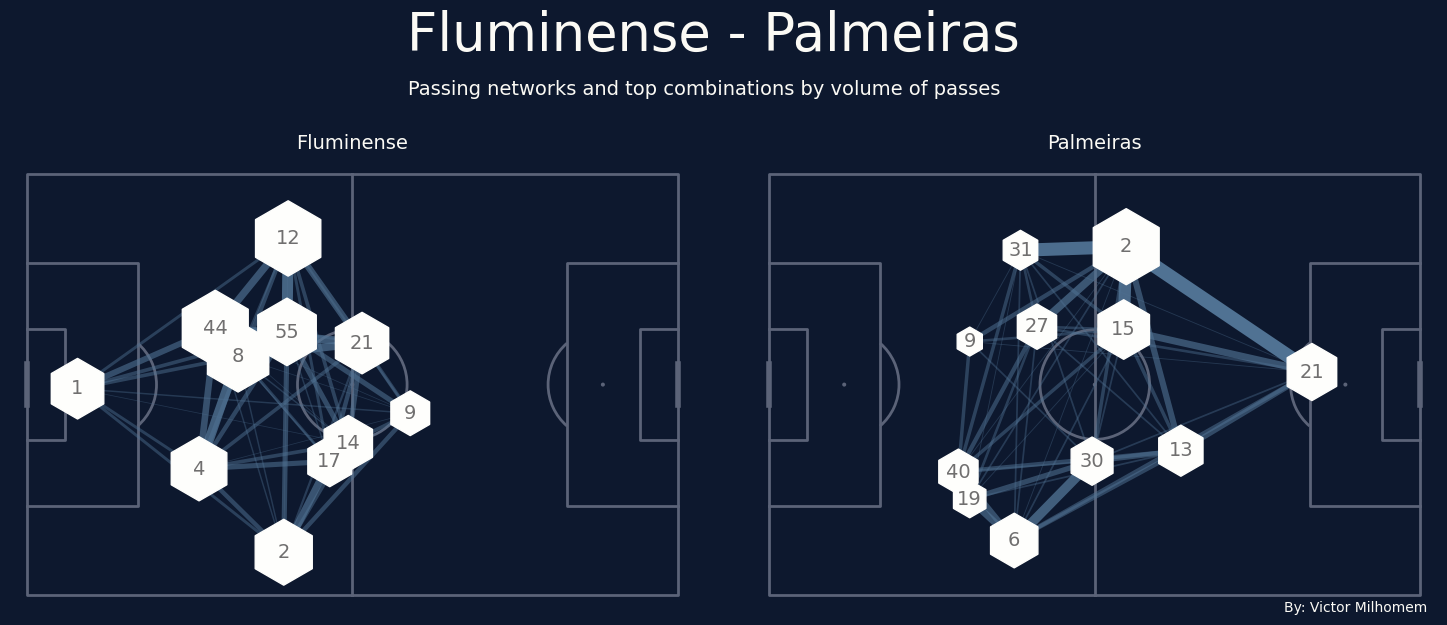

In [46]:
def create_passnet_plot_both_teams(
        home_passes_between_df, home_average_locs_and_count_df, 
        away_passes_between_df, away_average_locs_and_count_df, 
        teams_dict, 
        main_color):
    
    home_team_id = list(teams_dict.keys())[0]  # selected home team
    away_team_id = list(teams_dict.keys())[1]  # selected home team


    # create plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    axes = axes.flat
    plt.tight_layout()
    fig.set_facecolor("#0D182E")

    # home team viz
    pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
    axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

    # away team viz
    pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)
    axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14)

    plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=38)
    subtitle = "Passing networks and top combinations by volume of passes"
    plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)
    plt.text(90, -3, "By: Victor Milhomem", horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=10)
    plt.show()

create_passnet_plot_both_teams(home_passes_between_df, home_average_locs_and_count_df, 
        away_passes_between_df, away_average_locs_and_count_df, 
        teams_dict,main_color = '#FBFAF5')

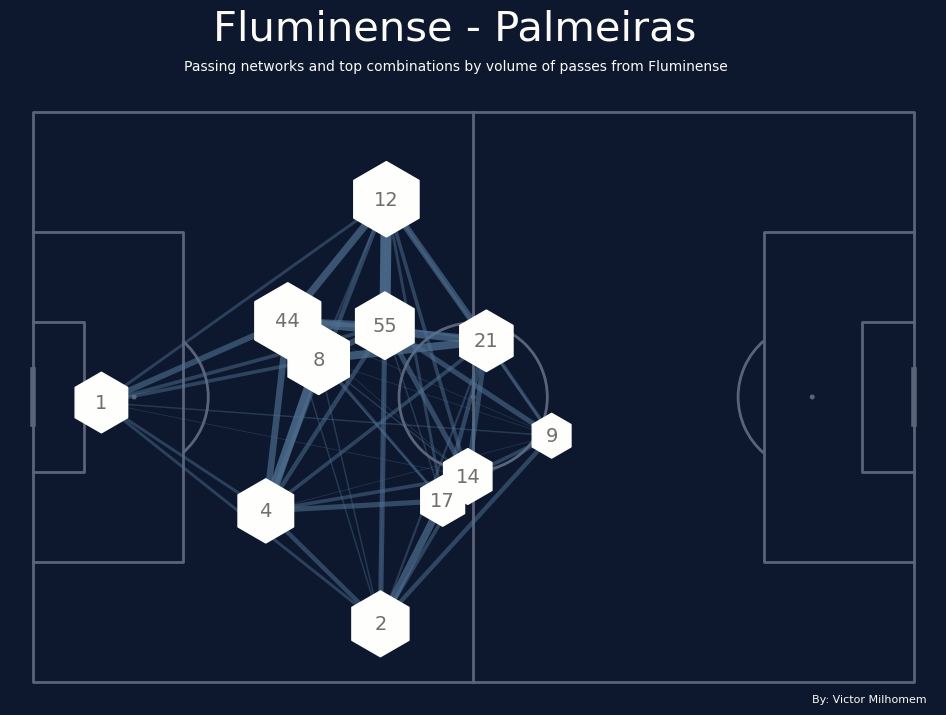

In [47]:
def create_passnet_plot_single_teams(
        home_passes_between_df, home_average_locs_and_count_df, 
        away_passes_between_df, away_average_locs_and_count_df, 
        teams_dict, 
        main_color, home=True):
    
    home_team_id = list(teams_dict.keys())[0]  # selected home team
    away_team_id = list(teams_dict.keys())[1]  # selected home team
    # create plot
    fig, axes = plt.subplots(1, 1, figsize=(15, 8))
    fig.set_facecolor("#0D182E")
    if home:
        # home team viz
        pass_network_visualization(axes, home_passes_between_df, home_average_locs_and_count_df)
    else:
        pass_network_visualization(axes, away_passes_between_df, away_average_locs_and_count_df)

    plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=30)
    subtitle = f"Passing networks and top combinations by volume of passes from {teams_dict[home_team_id if home else away_team_id]}"
    plt.text(48, 108, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=10)
    plt.text(95, -3, "By: Victor Milhomem", horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=8)
    plt.show()

create_passnet_plot_single_teams(
        home_passes_between_df, home_average_locs_and_count_df, 
        away_passes_between_df, away_average_locs_and_count_df, 
        teams_dict, 
        main_color= '#FBFAF5', home=True)